## Global Ratio of Created versus Modified Buildings

In [1]:
start_year = 2018
filter_keyword = 'microsoft/BuildingFootprints'
data_path = '/data/processing/ohsome-stats-by-year-full/*/*.parquet'


sql = f"""
COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,CASE
            WHEN contains(tags['source'][1], '{filter_keyword}') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("{data_path}", hive_partitioning=1)
        WHERE
            year >= {start_year}
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as changeset_timestamps
        ,len(array_agg(b.contrib_type)) as n_contributions
    FROM new_osm_ids as a
    LEFT JOIN read_parquet("{data_path}", hive_partitioning=1) as b ON
        a.osm_id = b.osm_id
    WHERE b.year >= {start_year}
    GROUP BY a.osm_id
    )
    SELECT
        source_microsoft
        ,date_trunc('year', creation_timestamp) as creation_year
        ,count(*) as all_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) as modified_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) / count(*) modified_ways_share
        ,AVG(n_contributions) as avg_n_contributions
    FROM new_osm_ids_agg
    GROUP BY source_microsoft, creation_year
    ORDER BY source_microsoft, creation_year
)
TO 'contribution_pattern_global.csv' (HEADER, DELIMITER ',');
"""
print(sql)


COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,CASE
            WHEN contains(tags['source'][1], 'microsoft/BuildingFootprints') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("/data/processing/ohsome-stats-by-year-full/*/*.parquet", hive_partitioning=1)
        WHERE
            year >= 2018
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as changeset_timestamps
     

Run the script above in duckdb and upload the file to GitHub. 
Then continue with the steps below.

In [2]:
import pandas as pd
import datetime

In [3]:
# create a plot of the results
df = pd.read_csv("../data/contribution_pattern_global.csv")
df["creation_year"] = pd.to_datetime(df["creation_year"])
df["label"] = "non-AI"
df.loc[df["source_microsoft"] == 1 , "label"] = "AI-generated"
df["modified_ways_share"] = 100 * df["modified_ways_share"] 
display(df)

,source_microsoft,creation_year,all_ways,modified_ways,modified_ways_share,avg_n_contributions,label
0,0,2018-01-01 00:00:00+00:00,66861328,18938305,28.324751,1.392765,non-AI
1,0,2019-01-01 00:00:00+00:00,48658594,14044785,28.863935,1.392791,non-AI
2,0,2020-01-01 00:00:00+00:00,58904244,17218829,29.231899,1.381957,non-AI
3,0,2021-01-01 00:00:00+00:00,61696757,12675992,20.545637,1.272972,non-AI
4,0,2022-01-01 00:00:00+00:00,51015106,7743386,15.178614,1.187175,non-AI
5,0,2023-01-01 00:00:00+00:00,28229229,3705898,13.127875,1.157783,non-AI
6,1,2019-01-01 00:00:00+00:00,14273,4051,28.382260,1.317032,AI-generated
7,1,2020-01-01 00:00:00+00:00,2693139,663977,24.654390,1.315124,AI-generated
8,1,2021-01-01 00:00:00+00:00,3531430,908918,25.737959,1.335260,AI-generated
9,1,2022-01-01 00:00:00+00:00,6948531,867846,12.489633,1.142072,AI-generated


In [4]:
# add data without considering USA
# create a plot of the results
df_countries = pd.read_csv("../data/contribution_pattern_per_country.csv")
df_countries["creation_year"] = pd.to_datetime(df_countries["creation_year"])
df_countries["label"] = "non-AI (without USA)"
df_countries.loc[df_countries["source_microsoft"] == 1 , "label"] = "AI-generated (without USA)"

df_without_usa = df_countries[
    (df_countries["country_iso_a3"] != 'USA')
    &
    (df_countries["creation_year"] > '2019-01-01')
]
df_without_usa_grouped = df_without_usa.groupby(["source_microsoft", "label", "creation_year"]).agg(
    modified_ways = pd.NamedAgg(column="modified_ways", aggfunc="sum"),
    all_ways = pd.NamedAgg(column="all_ways", aggfunc="sum"),
)

df_without_usa_grouped["modified_ways_share"] = 100 * df_without_usa_grouped["modified_ways"] / df_without_usa_grouped["all_ways"]
display(df_without_usa_grouped)

modified_ways  \
source_microsoft label                      creation_year                              
0                non-AI (without USA)       2020-01-01 00:00:00+00:00       15529465   
                                            2021-01-01 00:00:00+00:00       11896957   
                                            2022-01-01 00:00:00+00:00        7153446   
                                            2023-01-01 00:00:00+00:00        3073681   
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00          71734   
                                            2021-01-01 00:00:00+00:00          32120   
                                            2022-01-01 00:00:00+00:00         484497   
                                            2023-01-01 00:00:00+00:00         407557   

                                                                       all_ways  \
source_microsoft label                      creation_year                         
0                non-AI (without USA)       2020-01-01 00:00:00+00:00  53350889   
                                            2021-01-01 00:00:00+00:00  56371195   
                                            2022-01-01 00:00:00+00:00  45078255   
                                            2023-01-01 00:00:00+00:00  25791331   
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00    282442   
                                            2021-01-01 00:00:00+00:00    361169   
                                            2022-01-01 00:00:00+00:00   3588018   
                                            2023-01-01 00:00:00+00:00   3231975   

                                                                       modified_ways_share  
source_microsoft label                      creation_year                                   
0                non-AI (without USA)       2020-01-01 00:00:00+00:00            29.108165  
                                            2021-01-01 00:00:00+00:00            21.104674  
                                            2022-01-01 00:00:00+00:00            15.868951  
                                            2023-01-01 00:00:00+00:00            11.917497  
1                AI-generated (without USA) 2020-01-01 00:00:00+00:00            25.397781  
                                            2021-01-01 00:00:00+00:00             8.893344  
                                            2022-01-01 00:00:00+00:00            13.503193  
                                            2023-01-01 00:00:00+00:00            12.610153

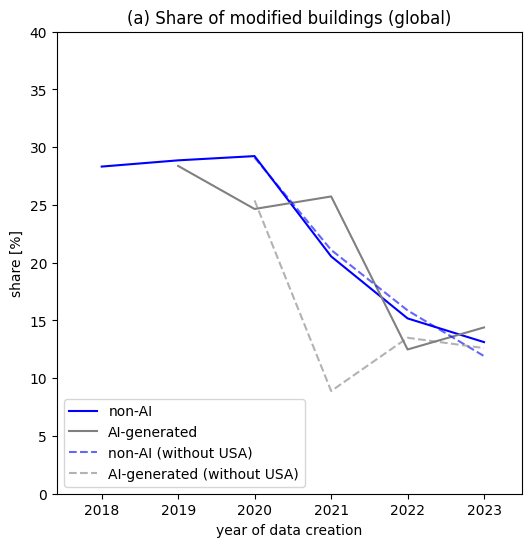

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))

sns.lineplot(
    x='creation_year', 
    y='modified_ways_share',
    hue='label', 
    data=df,
    palette=['blue', 'grey'],
)

sns.lineplot(
    x='creation_year', 
    y='modified_ways_share',
    hue='label', 
    data=df_without_usa_grouped,
    linestyle='--',
    palette=['blue', 'grey'],
    alpha=0.6
)

plt.ylim((0, 40))
plt.xlim((
    datetime.datetime(2017,6,1),
    datetime.datetime(2023,7,1)
))
plt.ylabel("share [%]")
plt.xlabel("year of data creation")
plt.legend(loc="lower left")
plt.title("(a) Share of modified buildings (global)")
plt.savefig(
    "../plots/contribution_pattern_global.png",
    bbox_inches='tight',
    dpi=300
)
plt.show()

## Contribution Pattern per Country

In [6]:
start_year = 2018
filter_keyword = 'microsoft/BuildingFootprints'
data_path = '/data/processing/ohsome-stats-by-year-full/*/*.parquet'


sql = f"""
COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,unnest(country_iso_a3) as country_iso_a3
          ,CASE
            WHEN contains(tags['source'][1], '{filter_keyword}') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("{data_path}", hive_partitioning=1)
        WHERE
            year >= {start_year}
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,a.country_iso_a3
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,array_agg(to_timestamp(b.changeset_timestamp/1000)) as changeset_timestamps
        ,len(array_agg(b.contrib_type)) as n_contributions
    FROM new_osm_ids as a
    LEFT JOIN read_parquet("{data_path}", hive_partitioning=1) as b ON
        a.osm_id = b.osm_id
    WHERE b.year >= {start_year}
    GROUP BY a.osm_id, a.country_iso_a3
    )
    SELECT
        country_iso_a3
        ,source_microsoft
        ,date_trunc('year', creation_timestamp) as creation_year
        ,count(*) as all_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) as modified_ways
        ,SUM(CASE when n_contributions > 1 THEN 1 ELSE 0 END) / count(*) modified_ways_share
        ,AVG(n_contributions) as avg_n_contributions
    FROM new_osm_ids_agg
    GROUP BY country_iso_a3, source_microsoft, creation_year
    ORDER BY country_iso_a3, source_microsoft, creation_year
)
TO 'contribution_pattern_per_country.csv' (HEADER, DELIMITER ',');
"""
print(sql)


COPY
(
    -- analyse if a contribution has been updated again
    WITH new_osm_ids AS (
        SELECT
          osm_id
          ,tags
          ,changeset_tags
          ,contrib_type
          ,unnest(country_iso_a3) as country_iso_a3
          ,CASE
            WHEN contains(tags['source'][1], 'microsoft/BuildingFootprints') THEN 1
            ELSE 0
          END AS source_microsoft
        FROM read_parquet("/data/processing/ohsome-stats-by-year-full/*/*.parquet", hive_partitioning=1)
        WHERE
            year >= 2018
            AND
            tags['building'][1] is not null
            AND
            contrib_type = 'CREATED'
            AND
            osm_type = 'way'
    ),
    -- aggregate by osm id
    new_osm_ids_agg as (
    SELECT
        a.osm_id
        ,a.country_iso_a3
        ,min(to_timestamp(b.changeset_timestamp/1000)) as creation_timestamp
        ,max(source_microsoft) as source_microsoft
        ,array_agg(b.contrib_type) as contrib_types
        ,arr

In [7]:
# create a plot of the results
df = pd.read_csv("../data/contribution_pattern_per_country.csv")
df["creation_year"] = pd.to_datetime(df["creation_year"])
df["label"] = "non-AI"
df.loc[df["source_microsoft"] == 1 , "label"] = "AI (Microsoft Buildings)"
df["modified_ways_share"] = 100 * df["modified_ways_share"]
display(df)

,country_iso_a3,source_microsoft,creation_year,all_ways,modified_ways,modified_ways_share,avg_n_contributions,label
0,AFG,0,2018-01-01 00:00:00+00:00,18950,17024,89.836412,2.076675,non-AI
1,AFG,0,2019-01-01 00:00:00+00:00,21756,12760,58.650487,1.705047,non-AI
2,AFG,0,2020-01-01 00:00:00+00:00,355956,125630,35.293688,1.501023,non-AI
3,AFG,0,2021-01-01 00:00:00+00:00,1044029,73426,7.032946,1.073799,non-AI
4,AFG,0,2022-01-01 00:00:00+00:00,252003,34297,13.609759,1.150601,non-AI
...,...,...,...,...,...,...,...,...
1613,ZWE,0,2021-01-01 00:00:00+00:00,123306,41743,33.853178,1.399534,non-AI
1614,ZWE,0,2022-01-01 00:00:00+00:00,73134,6325,8.648508,1.093363,non-AI
1615,ZWE,0,2023-01-01 00:00:00+00:00,42250,2229,5.275740,1.056781,non-AI
1616,ZWE,1,2022-01-01 00:00:00+00:00,121,0,0.000000,1.000000,AI (Microsoft Buildings)


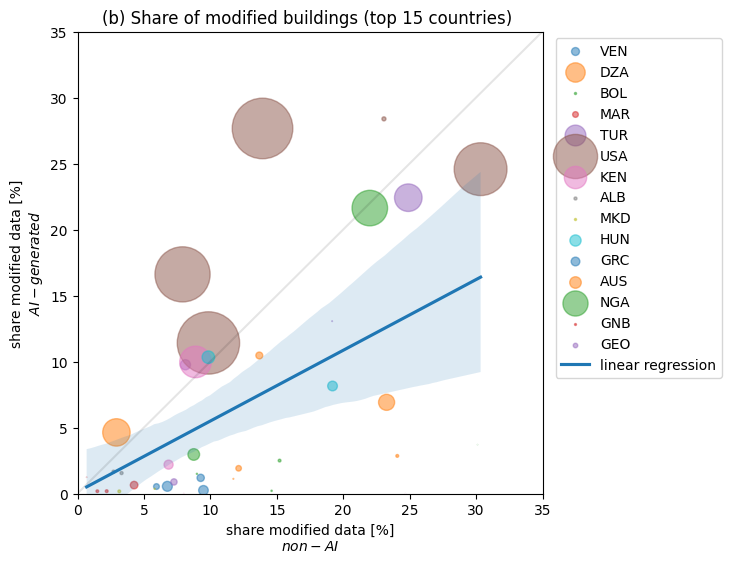

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np


top_15_countries_percentage = [
    'VEN',
    'DZA',
    'BOL',
    'MAR',
    'TUR',
    'USA',
    'KEN',
    'ALB',
    'MKD',
    'HUN',
    'GRC',
    'AUS',
    'NGA',
    'GNB',
    'GEO'
]


x_list = []
y_list = []
weights_list = []

plt.figure(figsize=(6,6))
plt.plot(
    [0,35],
    [0,35],
    linestyle='-',
    color='black',
    alpha=0.1
)

for country in top_15_countries_percentage:
    df_filtered_ai = df[
        (df["country_iso_a3"] == country)
        &
        (df["source_microsoft"] == 1)
    ]
    years_with_ai = df_filtered_ai["creation_year"].to_list()

    df_filtered_non_ai = df[
        (df["country_iso_a3"] == country)
        &
        (df["source_microsoft"] == 0)
        &
        (df["creation_year"].isin(years_with_ai))
    ]

    x = df_filtered_non_ai["modified_ways_share"].to_numpy()
    y = df_filtered_ai["modified_ways_share"].to_numpy()
    
    plt.scatter(
        x,
        y,
        s=0.6 * df_filtered_ai["all_ways"] / 10**3,
        alpha=0.5,
        label=country
    )

    x_list += list(x)
    y_list += list(y)
    weights_list += df_filtered_ai["all_ways"].to_list()


sns.regplot(
    x=x_list,
    y=y_list,
    scatter=False,
    label="linear regression"
)

plt.legend(
    loc='upper right',
    bbox_to_anchor=(1.4, 1)
)
plt.title("(b) Share of modified buildings (top 15 countries) ")
plt.xlabel("share modified data [%]\n$\it{non-AI}$")
plt.ylabel("share modified data [%]\n$\it{AI-generated}$")
plt.xlim((0, 35))
plt.ylim((0, 35))
plt.savefig(
    "../plots/contribution_pattern_per_country_scatter.png",
    bbox_inches='tight',
    dpi=300
)
plt.show()